Import necessary libraries:

In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Loading data and labels from local path and choose first column of vibration signals as input:

In [2]:
data = pd.read_csv('final_dataset.csv')
data_column = data.iloc[:, 0].values

labels = pd.read_csv('label.csv').values
y = labels.squeeze(1).tolist()

Prepare the data for model :

In [3]:
scaler = StandardScaler()
data_column_normalized = scaler.fit_transform(data_column.reshape(-1, 1)).flatten()

data_tensor = torch.tensor(data_column_normalized, dtype=torch.float32)
X = data_tensor.reshape((16828, 1000))
X = X.unsqueeze(1)

error = torch.tensor(list(map(lambda x: [x]*601, y)))
Y = error.flatten()

Split data into three parts ; Train , valid , test and put them in separate Dataloader :

In [45]:
X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(X, Y-1, test_size=0.3, random_state=42, stratify=Y-1)
X_train , X_valid , Y_train , Y_valid = train_test_split (X_train_valid , Y_train_valid , test_size= 0.25 , random_state=42 , stratify=Y_train_valid)

batch_size = 100
train_dataset = TensorDataset(X_train, Y_train)
valid_dataset = TensorDataset(X_valid,Y_valid)
test_dataset = TensorDataset(X_test, Y_test)

torch.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Define a Residual Block:

The ResidualBlock class defines a single residual block for the model. The constructor initializes the layers, including convolutional layers, batch normalization, and an optional downsampling layer for matching dimensions. The forward method specifies the data flow through the block, applying the layers sequentially and adding the shortcut connection to form the residual mapping.

In [46]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out


Model Definition: 

   This class defines a 1D ResNet model for processing sequential data. It utilizes three main components:

Initial Convolution and Pooling: The input data passes through a convolutional layer, batch normalization, a ReLU activation, and a max-pooling layer to reduce its spatial dimensions while extracting features.

Residual Layers: The model contains three stages (layers), each built using the _make_layer method. These stages stack multiple residual blocks, enabling efficient gradient flow and feature learning at different levels of abstraction.

Global Pooling and Classification: After feature extraction, the output is reduced to a single value per channel using an adaptive average pooling layer, followed by a fully connected layer for classification.

_make_layer Function:

   This helper function creates a sequential block of residual layers. It handles the downsampling of input dimensions when needed, ensuring compatibility between input and output dimensions across different layers.



In [47]:
class ResNet1D(nn.Module):
    def __init__(self, block, layers, num_classes=4):
        super(ResNet1D, self).__init__()
        self.in_channels = 16
        self.conv = nn.Conv1d(1, 16, kernel_size=7, stride=2, padding=3)
        self.bn = nn.BatchNorm1d(16)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


Make sure GPU is available :

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Model Initialization and Training Setup:

The random seed is fixed using torch.manual_seed(1) to ensure reproducibility of results. The ResNet1D model is defined with three layers, each containing two residual blocks, and is set to classify data into 4 output classes. The model is moved to the available device (CPU or GPU). The loss function is defined as cross-entropy loss (nn.CrossEntropyLoss), suitable for multi-class classification tasks. The optimizer chosen is Adam (torch.optim.Adam) with a learning rate of 0.001 for efficient parameter optimization.

In [49]:
torch.manual_seed(42)

model = ResNet1D(ResidualBlock, [2, 2, 2], num_classes=4).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Training and Evaluation Function:

   This function performs the training and validation process for a given model over multiple epochs.

In [50]:
def train_and_evaluate(model, num_epochs, train_loader, valid_loader):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct_train = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct_train.sum()

        loss_hist_train[epoch] /= len(train_loader.dataset)
        accuracy_hist_train[epoch] /= len(train_loader.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct_valid = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct_valid.sum()

        loss_hist_valid[epoch] /= len(valid_loader.dataset)
        accuracy_hist_valid[epoch] /= len(valid_loader.dataset)

        # if (epoch + 1) % 10 == 0:
        print(f'Epoch[{epoch+1}]: T_Acc: {accuracy_hist_train[epoch]:.3f}   V_Acc: {accuracy_hist_valid[epoch]:.3f}')

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


Model Training and Evaluation:

The model is trained for 20 epochs using the train_and_evaluate function. This function handles both the training and validation phases for each epoch. During training, the model learns by minimizing the loss function (CrossEntropyLoss) using the Adam optimizer. After each epoch, the function evaluates the model on the validation dataset to track performance, including loss and accuracy.

In [51]:
torch.manual_seed(42)
num_epochs = 20
result = train_and_evaluate(model, num_epochs, train_loader, valid_loader)

Epoch[1]: T_Acc: 0.710   V_Acc: 0.920
Epoch[2]: T_Acc: 0.878   V_Acc: 0.947
Epoch[3]: T_Acc: 0.934   V_Acc: 0.934
Epoch[4]: T_Acc: 0.930   V_Acc: 0.970
Epoch[5]: T_Acc: 0.954   V_Acc: 0.950
Epoch[6]: T_Acc: 0.977   V_Acc: 0.969
Epoch[7]: T_Acc: 0.979   V_Acc: 0.931
Epoch[8]: T_Acc: 0.977   V_Acc: 0.993
Epoch[9]: T_Acc: 0.984   V_Acc: 0.992
Epoch[10]: T_Acc: 0.989   V_Acc: 0.969
Epoch[11]: T_Acc: 0.994   V_Acc: 0.996
Epoch[12]: T_Acc: 0.987   V_Acc: 0.993
Epoch[13]: T_Acc: 0.990   V_Acc: 0.939
Epoch[14]: T_Acc: 0.990   V_Acc: 0.995
Epoch[15]: T_Acc: 0.991   V_Acc: 0.992
Epoch[16]: T_Acc: 0.992   V_Acc: 0.996
Epoch[17]: T_Acc: 0.994   V_Acc: 0.998
Epoch[18]: T_Acc: 0.996   V_Acc: 0.996
Epoch[19]: T_Acc: 0.996   V_Acc: 0.997
Epoch[20]: T_Acc: 0.994   V_Acc: 0.997


C:\Users\Albaloo Rayaneh\AppData\Local\Temp\ipykernel_20060\1430446203.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_acc_cpu = [torch.tensor(x).cpu().numpy() for x in result[2]]
C:\Users\Albaloo Rayaneh\AppData\Local\Temp\ipykernel_20060\1430446203.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_acc_cpu = [torch.tensor(x).cpu().numpy() for x in result[3]]


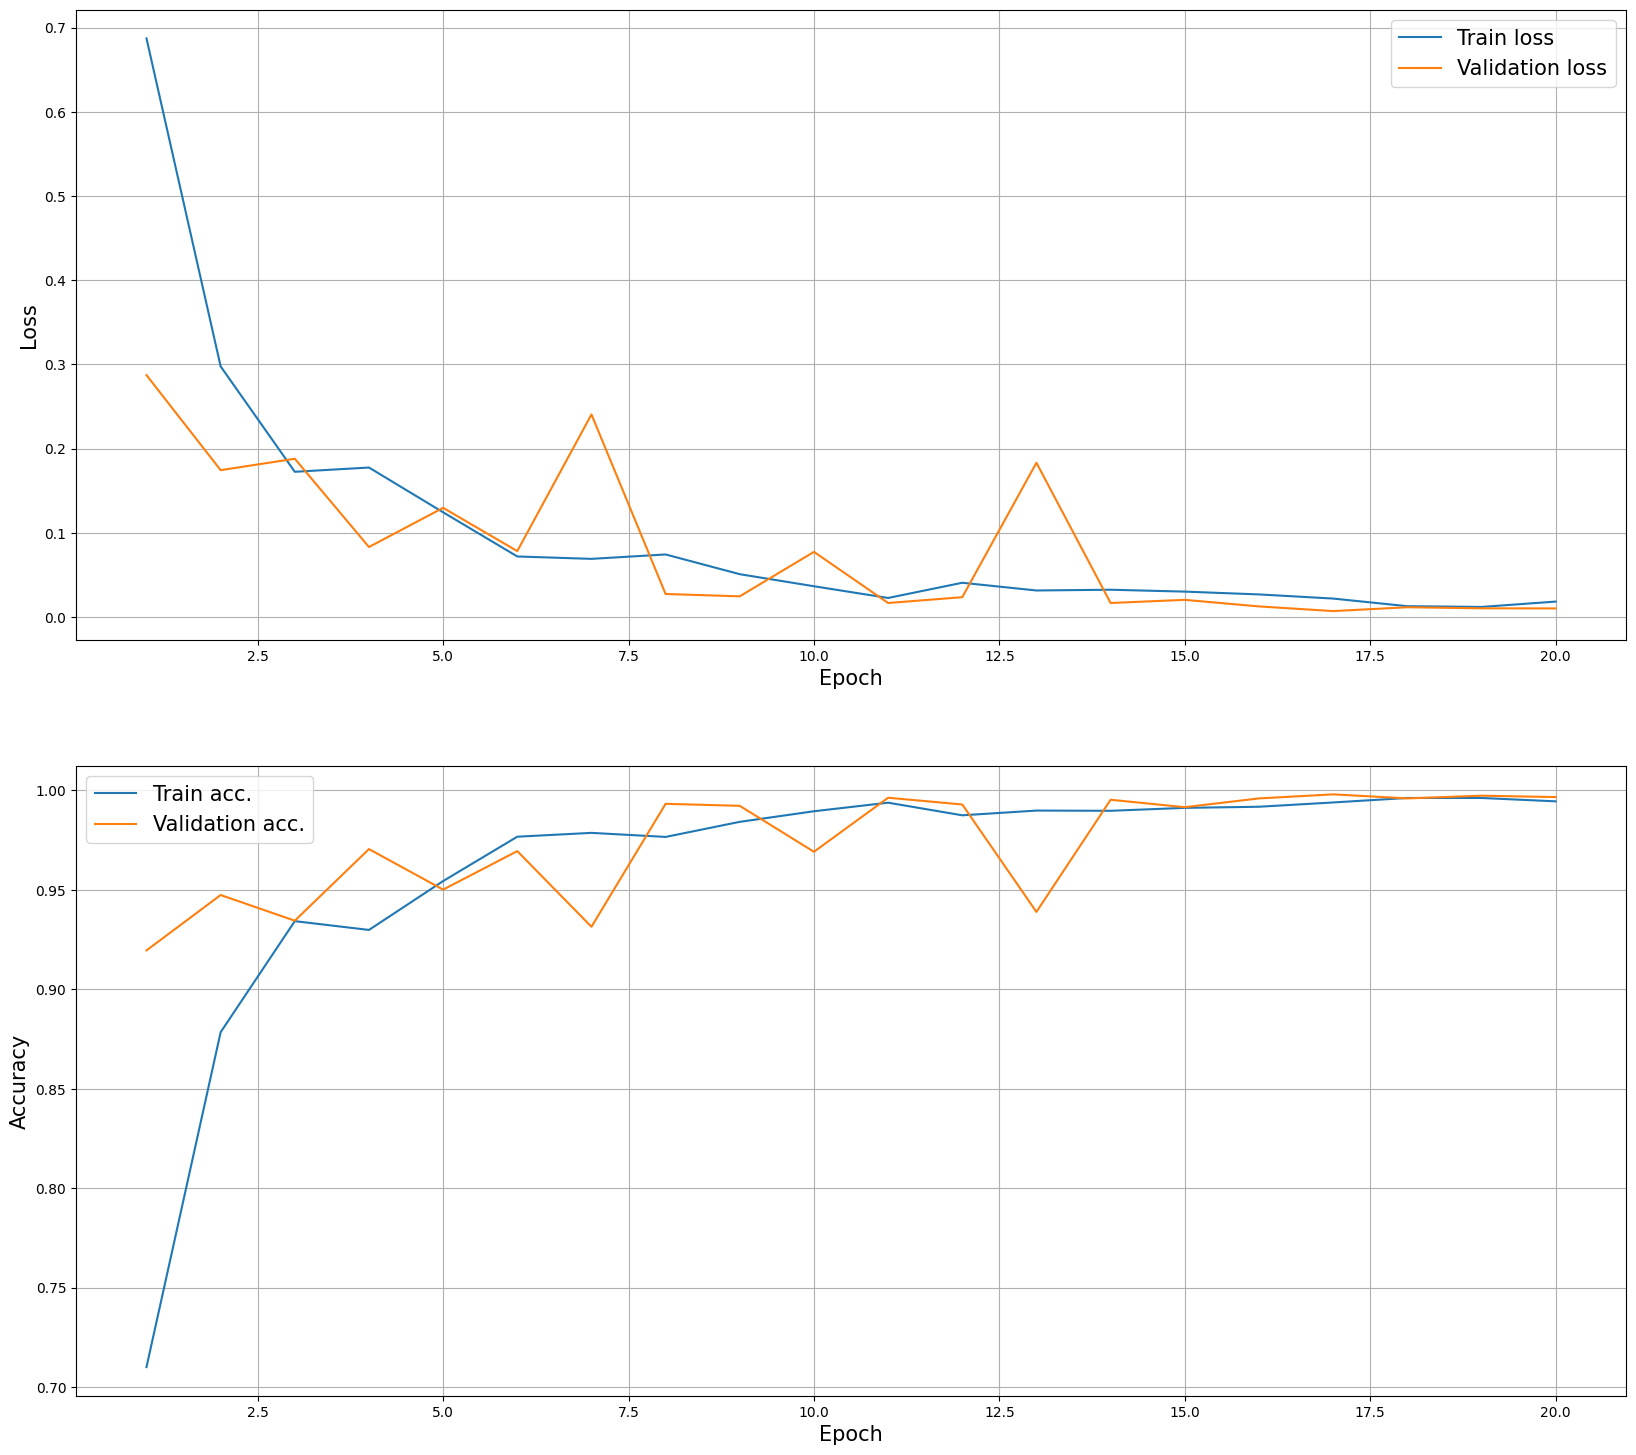

In [55]:
x_arr = np.arange(len(result[0])) + 1

train_loss_cpu = [torch.tensor(x).cpu().numpy() for x in result[0]]
valid_loss_cpu = [torch.tensor(x).cpu().numpy() for x in result[1]]
train_acc_cpu = [torch.tensor(x).cpu().numpy() for x in result[2]]
valid_acc_cpu = [torch.tensor(x).cpu().numpy() for x in result[3]]

fig = plt.figure(figsize=(20, 18))
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_arr, train_loss_cpu, label='Train loss')
ax.plot(x_arr, valid_loss_cpu, label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.grid(True)
ax.legend(fontsize=15)

ax = fig.add_subplot(2, 1, 2)
ax.plot(x_arr, train_acc_cpu, label='Train acc.')
ax.plot(x_arr, valid_acc_cpu, label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.grid(True)
plt.show()


Results Analysis:

The training and validation accuracy show excellent performance throughout the epochs. The training accuracy (T_Acc) quickly approaches 99.9% and eventually reaches 100%, indicating that the model successfully learns the training data. Validation accuracy (V_Acc) also remains consistently high, ranging between 98.4% and 99.9%, with a peak of 99.9%. This suggests that the model generalizes well to unseen validation data, and no significant overfitting is observed despite the near-perfect training accuracy. The model demonstrates robust learning and effective optimization for this dataset.



The test_model function is designed to evaluate the model's performance on the test dataset.

In [24]:

def test_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            test_loss += loss_fn(pred, y_batch).item() * y_batch.size(0)
            correct += (torch.argmax(pred, dim=1) == y_batch).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {accuracy:.3f}')

test_model(model, test_loader)    

Test Loss: 0.007, Test Accuracy: 0.999


The model achieved excellent performance on the test set.




This section of the code is used to evaluate the model's prediction for a single sample from the test dataset

In [53]:
model.eval()

sample_data, actual_label = test_dataset[0] 

sample_data = sample_data.unsqueeze(0).to(device)

with torch.no_grad():
    prediction = model(sample_data)

probabilities = nn.Softmax(dim=1)(prediction)


predicted_label = torch.argmax(probabilities, dim=1).item()

print(f"Actual Label: {actual_label.item()}")
print(f"Predicted Label: {predicted_label}")
print(f"Probabilities: {probabilities.cpu().numpy()}")


Actual Label: 1
Predicted Label: 1
Probabilities: [[7.1678289e-05 9.9890757e-01 5.6763387e-05 9.6391933e-04]]




And finally, this section generates and visualizes a normalized confusion matrix to evaluate the model's classification performance on the test dataset.

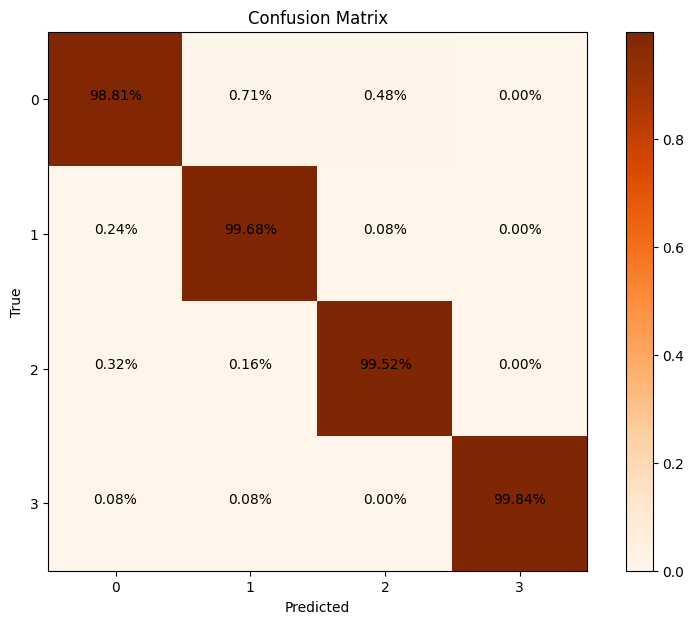

In [54]:

def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            all_preds.extend(torch.argmax(pred, dim=1).cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 7))
    plt.imshow(cm_normalized, interpolation='nearest', cmap='Oranges')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(set(all_labels)))
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            plt.text(j, i, f'{cm_normalized[i, j]:.2%}', horizontalalignment='center', color='black')

    plt.show()

plot_confusion_matrix(model, test_loader)
